In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
rep1_site = promoter[(115):(115+10)]
rep2_site = promoter[(115+20):(115+30)]

#promoter = promoter.replace(rep2_site, 'G'+ rep1_site[1:])
#rep2_site = 'G' + rep1_site[1:]

r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

In [6]:
num_mutants = 200

mutant_bank = []
for i in range(num_mutants):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [7]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 5000, 25

l_n_r1 = np.arange(0, 50, 2)

r1_AND = np.zeros((len(l_n_r1), num_mutants))
r2_AND = np.zeros((len(l_n_r1), num_mutants))

for i, n_r1 in enumerate(l_n_r1):
    for j in range(num_mutants):
        df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound,
                                [rnap_site, rep1_site, rep2_site],
                                *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat,
                                  ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                                preset_mutants=mutant_bank[j],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.median(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1_AND[i, j] = np.mean(footprint[(115):(115+10)])
        r2_AND[i, j] = np.mean(footprint[(115+20):(115+30)])    

In [8]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 5000, 25

l_n_r1 = np.arange(0, 50, 2)

r1_OR = np.zeros((len(l_n_r1), num_mutants))
r2_OR = np.zeros((len(l_n_r1), num_mutants))

for i, n_r1 in enumerate(l_n_r1):
    for j in range(num_mutants):
        df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound,
                                [rnap_site, rep1_site, rep2_site],
                                *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat,
                                  ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                                preset_mutants=mutant_bank[j],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.median(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        r1_OR[i, j] = np.mean(footprint[(115):(115+10)])
        r2_OR[i, j] = np.mean(footprint[(115+20):(115+30)])

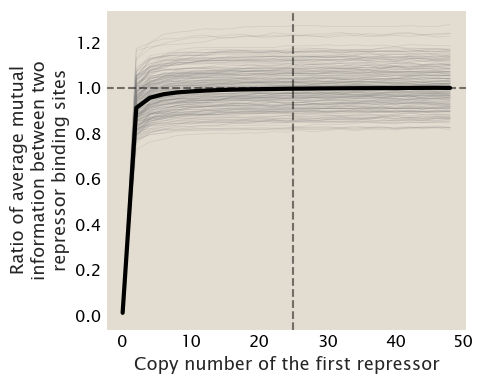

In [18]:
fig, ax = plt.subplots(figsize=(5,4))

for i in range(num_mutants):
    ax.plot(l_n_r1, np.asarray(r1_OR)[:, i] / np.asarray(r2_OR)[:, i], color='grey', alpha=0.2, linewidth=0.5)

ax.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=25, color='black', linestyle='--', alpha=0.5)

ax.plot(l_n_r1, np.mean(r1_OR, axis=1) / np.mean(r2_OR, axis=1),
           label='Second repressor binding site', color='black', linewidth=3)

ax.set_xlabel('Copy number of the first repressor', fontsize=13)
ax.set_ylabel('Ratio of average mutual\ninformation between two\nrepressor binding sites', fontsize=13)

plt.tight_layout()
plt.savefig('../rebuttal_plots/figR6.pdf', dpi=300)

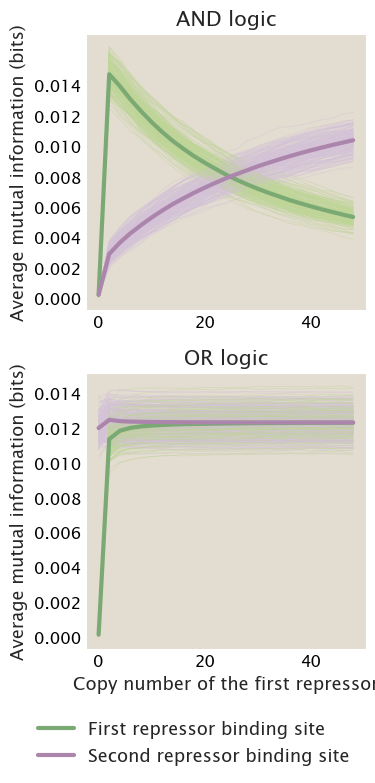

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(4,8))
ax1, ax2 = axes

for i in range(num_mutants):
    ax1.plot(l_n_r1, np.asarray(r1_AND)[:, i], color='#BFD598', alpha=0.5, linewidth=0.5)
    ax1.plot(l_n_r1, np.asarray(r2_AND)[:, i], color='#D4C2D9', alpha=0.5, linewidth=0.5)
ax1.plot(l_n_r1, np.mean(r1_AND, axis=1), label='First repressor binding site', color='#7AA974', linewidth=3)
ax1.plot(l_n_r1, np.mean(r2_AND, axis=1), label='Second repressor binding site', color='#AB85AC', linewidth=3)
ax1.set_ylabel('Average mutual information (bits)', fontsize=13)
ax1.set_title('AND logic', fontsize=15)
ax1.set_yticks(np.arange(0, 0.015, 0.002))

for i in range(num_mutants):
    ax2.plot(l_n_r1, np.asarray(r1_OR)[:, i], color='#BFD598', alpha=0.5, linewidth=0.5)
    ax2.plot(l_n_r1, np.asarray(r2_OR)[:, i], color='#D4C2D9', alpha=0.5, linewidth=0.5)
ax2.plot(l_n_r1, np.mean(r1_OR, axis=1), label='First repressor binding site', color='#7AA974', linewidth=3)
ax2.plot(l_n_r1, np.mean(r2_OR, axis=1), label='Second repressor binding site', color='#AB85AC', linewidth=3)
ax2.set_xlabel('Copy number of the first repressor', fontsize=13)
ax2.set_ylabel('Average mutual information (bits)', fontsize=13)
ax2.set_title('OR logic', fontsize=15)
#ax2.set_ylim(0.008, 0.013)
ax2.legend(bbox_to_anchor=(1, -0.2), frameon=False, fontsize=13)

plt.tight_layout()
plt.savefig('../rebuttal_plots/figR7.pdf', dpi=300)

In [10]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 5000, 25

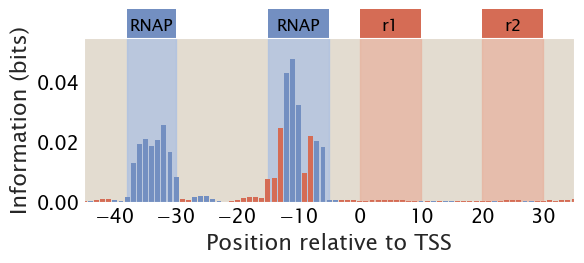

In [11]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../plots/fig7/knockout_doublerep_AND_fp1.pdf')

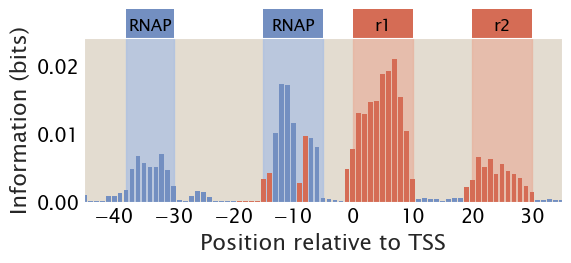

In [12]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../plots/fig7/knockout_doublerep_AND_fp2.pdf')

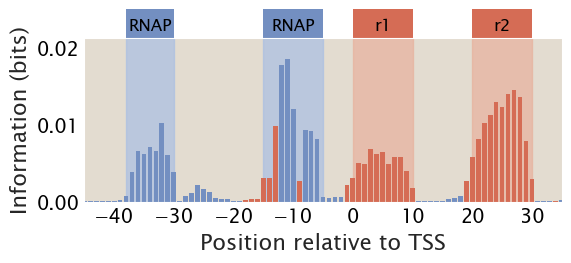

In [13]:
n_r1 = 50

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../plots/fig7/knockout_doublerep_AND_fp3.pdf')

In [14]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -14, -14
e_int = -5
n_p, n_r2 = 5000, 25

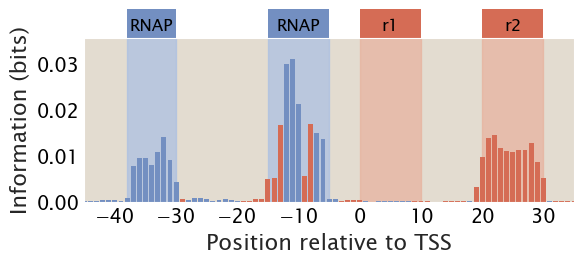

In [15]:
n_r1 = 0

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../plots/fig7/knockout_doublerep_OR_fp1.pdf')

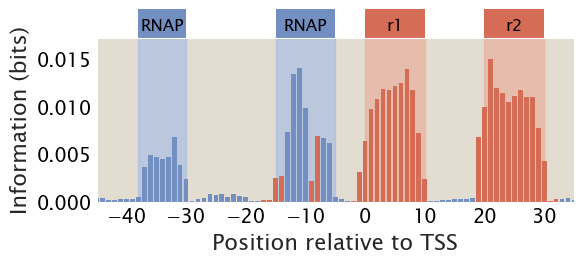

In [16]:
n_r1 = 5

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../plots/fig7/knockout_doublerep_OR_fp2.pdf')

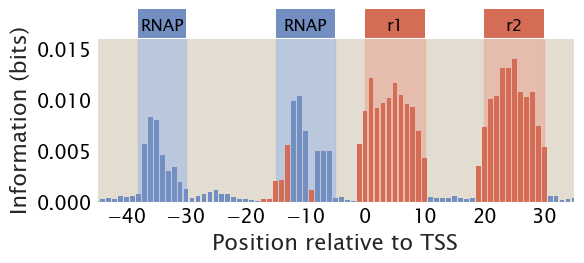

In [17]:
n_r1 = 50

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (0, 10, 'R', 'r1'), (20, 30, 'R', 'r2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 35), fig_width=6,
                               legend_xcoord=1.35,
                               outfile='../plots/fig7/knockout_doublerep_OR_fp3.pdf')